In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
#tickers = ['IGLB', 'HYG', 'SPY', 'MBB','BOTZ','ICLN','PAVE']
tickers = ['BOTZ', 'HYG', 'ICLN', 'IGLB', 'MBB', 'PAVE', 'SPY']
yf_etf = yf.Tickers(tickers)

df = yf_etf.download(start='2010-01-01')
df = df['Close']
df

[*********************100%%**********************]  7 of 7 completed


,BOTZ,HYG,ICLN,IGLB,MBB,PAVE,SPY
Date,,,,,,,
2010-01-04,NaN,39.491512,16.686979,27.838345,73.872696,NaN,86.860069
2010-01-05,NaN,39.678886,17.133623,28.129620,74.220879,NaN,87.090019
2010-01-06,NaN,39.781448,17.280067,28.129620,74.220879,NaN,87.151283
2010-01-07,NaN,39.942085,17.316679,28.113163,74.102531,NaN,87.519188
2010-01-08,NaN,40.004532,17.470442,28.102179,74.206955,NaN,87.810448
...,...,...,...,...,...,...,...
2024-03-15,31.650000,77.070000,13.420000,50.820000,91.669998,38.139999,509.829987
2024-03-18,31.870001,77.250000,13.490000,50.639999,91.559998,38.209999,512.859985
2024-03-19,31.889999,77.559998,13.420000,50.790001,91.879997,38.520000,515.710022


### Efficient Frontier 구축을 위한 데이터 준비
- 자산들의 연간 수익률
- 자산들의 공분산

In [4]:
# 일간수익률의 1년 중 시장이 열리는 일수를 곱해 기대수익률을 만든다.
ret_daily = df.pct_change() # 일간수익률

yearly_count = ret_daily.resample('Y').count() # 각 연도별 데이터 포인트 개수

ret_annual = ret_daily.resample('Y').mean()

for year in yearly_count.index.year:
    count = yearly_count.loc[str(year)].max() # 해당 연도의 데이터 포인트 개수
    # 해당 연도의 데이터에 개수를 곱함
    ret_annual.loc[ret_annual.index.year == year] *= count

ret_annual

,BOTZ,HYG,ICLN,IGLB,MBB,PAVE,SPY
Date,,,,,,,
2010-12-31,NaN,0.108920,-0.299809,0.104124,0.053700,NaN,0.139351
2011-12-31,NaN,0.073292,-0.508054,0.163414,0.057467,NaN,0.045278
2012-12-31,NaN,0.106941,-0.109235,0.104750,0.018536,NaN,0.156389
2013-12-31,NaN,0.057863,0.423683,-0.076855,-0.019025,NaN,0.286227
2014-12-31,NaN,0.020199,-0.030108,0.156501,0.062225,NaN,0.132652
2015-12-31,NaN,-0.049209,0.068003,-0.052359,0.011688,NaN,0.024147
2016-12-31,0.018678,0.129275,-0.156516,0.090185,0.011039,NaN,0.121847
2017-12-31,0.464387,0.059696,0.202735,0.116665,0.024927,0.139459,0.198767
2018-12-31,-0.305213,-0.019249,-0.080117,-0.069441,0.008491,-0.193902,-0.032317


In [5]:
# 일간수익률의 공분산을 계산하고 연간 단위로 만든다.

grouped = ret_daily.groupby(ret_daily.index.year)

cov_annual = {}

for year, group in grouped:
    cov_annual[year] = group.cov()  # 일간수익률 공분산 행렬 계산
    count = yearly_count.loc[str(year)].max() # 각 연도 데이터 포인트의 개수
    # print(f'{year}:{count}') # for debugging
    cov_annual[year] *= count

cov_annual[2010]

,BOTZ,HYG,ICLN,IGLB,MBB,PAVE,SPY
BOTZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HYG,NaN,0.008346,0.018429,-0.002265,-0.000343,NaN,0.012358
ICLN,NaN,0.018429,0.090133,-0.009084,-0.001260,NaN,0.043836
IGLB,NaN,-0.002265,-0.009084,0.011792,0.001628,NaN,-0.007705
MBB,NaN,-0.000343,-0.001260,0.001628,0.000764,NaN,-0.001289
PAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPY,NaN,0.012358,0.043836,-0.007705,-0.001289,NaN,0.031878


In [6]:
# # 일간수익률의 공분산을 계산하고 총 데이터 포인트 개수만큼 곱하기 (이 계산이 맞나? 아닌듯;) 

# # 각 티커의 데이터 포인트 개수 (임의의 값으로 설정, 실제 데이터에 맞게 조정 필요)
# data_points = ret_daily.count()

# cov_daily = ret_daily.cov()

# # 각 티커의 데이터 포인트 개수를 고려하여 공분산 행렬에 곱하기
# cov_total = cov_daily.copy()

# for ticker in tickers:
#     cov_total[ticker] *= data_points[ticker]
# #    cov_total.loc[ticker] *= data_points[ticker]

# cov_total

In [7]:
# 포트폴리오의 수익률, 변동성, 투자 비중을 저장할 변수를 미리 준비
p_returns = []
p_volatility = []
p_weights = []

# 투자 자산의 수
n_assets = len(tickers)

# 투자 비중을 바꿔가며 생성할 포트폴리오의 수
n_ports = 1000000

# 임시로 2024년 변동성 지정
#cov_annual_tmp = cov_annual[2024]
#ret_annual_tmp = ret_annual.iloc[-1]


In [8]:
# # n_ports만큼 반복하면서 자산의 투자 비중을 랜덤하게 만들고 포트폴리오의 기대수익률, 변동성을 계산.
# # 계산한 수익률, 변동성, 투자 비중은 앞서 미리 준비한 변수, p_returns, p_volatility, p_weights에 저장한다.
# for i in range(n_ports):
#     wgt = np.random.random(n_assets) # 난수 생성
#     wgt /= np.sum(wgt) # 투자 비중 합계 100%를 위해 각 난수를 난수 합으로 나눈다
#     ret = np.dot(wgt, ret_annual_tmp) # 투자 비중*기대수익률로 기대수익률 계산
#     vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual_tmp, wgt))) # 변동성 계산
#     p_returns.append(ret) # 계산한 수익률 추가
#     p_volatility.append(vol) # 변동성 추가
#     p_weights.append(wgt) # 투자 비중 추가

In [9]:
# for i in range(n_ports):
#     # 자산 비중을 랜덤하게 생성하고 5% 단위로 조정
#     wgt = np.random.randint(0, 21, size=n_assets)  # 0에서 20까지의 정수 난수 생성 (4를 곱하면 최대 80%)
#     wgt = wgt * 0.05  # 5% 단위로 조정
#     wgt[-1] = 1 - wgt[:-1].sum()  # 나머지 비중을 마지막 자산에 할당하여 총합이 1이 되도록 조정
#     if wgt[-1] < 0 or wgt[-1] > 1: continue  # 비중이 유효 범위를 벗어나면 스킵
    
#     ret = np.dot(wgt, ret_annual_tmp)  # 투자 비중*기대수익률로 기대수익률 계산
#     vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual_tmp, wgt)))  # 변동성 계산
    
#     p_returns.append(ret)  # 계산한 수익률 추가
#     p_volatility.append(vol)  # 변동성 추가
#     p_weights.append(wgt)  # 투자 비중 추가

In [ ]:
import numpy as np
import itertools

n_assets = 7
n_ports = 296010  # 생성할 포트폴리오의 수
p_returns = []  # 포트폴리오 기대수익률 저장
p_volatility = []  # 포트폴리오 변동성 저장
p_weights = []  # 포트폴리오의 자산 비중 저장

# ret_annual_tmp와 cov_annual_tmp는 각각 연간 기대수익률과 공분산 행렬을 의미합니다.
# 여기서는 예시를 위해 임의의 값으로 대체합니다.
cov_annual_tmp = cov_annual[2024]
cov_annual_tmp = cov_annual_tmp @ cov_annual_tmp.T  # 대칭 행렬로 만들기
ret_annual_tmp = ret_annual.iloc[-1]

# 가능한 모든 비중 조합을 생성
all_combinations = list(itertools.product(range(21), repeat=n_assets))

# 가능한 조합에서 랜덤하게 n_ports만큼 선택
selected_combinations = np.random.choice(len(all_combinations), size=n_ports, replace=False)

for i in selected_combinations:
    wgt = np.array(all_combinations[i]) * 0.05
    wgt[-1] = 1 - wgt[:-1].sum()  # 나머지 비중을 마지막 자산에 할당

    ret = np.dot(wgt, ret_annual_tmp)  # 투자 비중*기대수익률로 기대수익률 계산
    vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual_tmp, wgt)))  # 변동성 계산ㄴ

    p_returns.append(ret)  # 계산한 수익률 추가
    p_volatility.append(vol)  # 변동성 추가
    p_weights.append(wgt)  # 투자 비중 추가


: 

In [9]:
# 완성된 3만 개의 포트폴리오를 차트로 그린다
p_volatility = np.array(p_volatility)
print(len(p_volatility))
p_returns = np.array(p_returns)
print(len(p_returns))

colors = np.random.randint(0, len(p_volatility), len(p_returns)) # 색상을 n_ports만큼 만든다

2646
2646


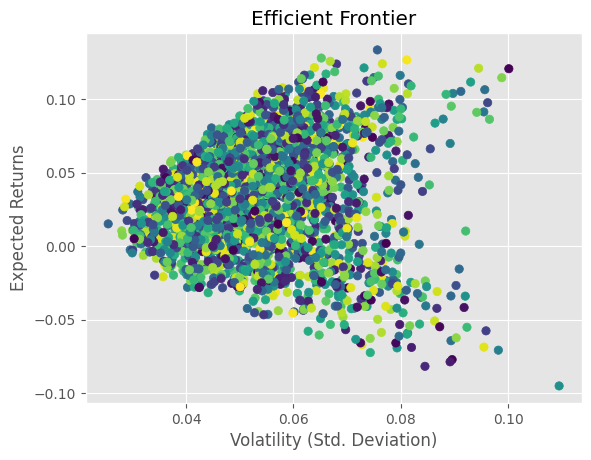

In [18]:
plt.style.use('ggplot')
plt.scatter(p_volatility, p_returns, c=colors, marker='o')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [19]:
# 소비자의 기준에 따른 자산, 비중 확인

target_return = 0.10 # 목표 수익률
target_volatility = 0.20 # 목표 변동성

# 목표에 가장 가까운 포인트 찾기
index = np.abs(np.array(p_returns) - target_return).argmin()
target_weights = p_weights[index]

print(f"목표 수익률: {target_return} \n해당 포인트의 자산 분배: \n{target_weights}")

목표 수익률: 0.1 
해당 포인트의 자산 분배: 
[0.2  0.   0.05 0.05 0.1  0.55 0.05]


In [20]:
pd.DataFrame(tickers, target_weights)

,0
0.20,BOTZ
0.00,HYG
0.05,ICLN
0.05,IGLB
0.10,MBB
0.55,PAVE
0.05,SPY


In [21]:
ret_annual.iloc[-1]

BOTZ    0.129178
HYG     0.010266
ICLN   -0.118112
IGLB   -0.023409
MBB    -0.014194
PAVE    0.141042
SPY     0.098645
Name: 2024-12-31 00:00:00, dtype: float64

In [23]:
# 목표 수익률에 가장 가까운 포트폴리오 n개 뽑고 변동성을 기준으로 오름차순 정렬하여 가장 변동성 낮은 것 출력

target_return = 0.2 # 목표 수익률
n = 10 # 선택할 포트폴리오 개수

# 1단계: 목표 수익률과의 차이 계산
returns_diff = np.abs(p_returns - target_return)

# 2단계: 수익률 차이를 기준으로 포트폴리오 정보를 포함한 튜플 생성 및 정렬
portfolios = sorted(zip(returns_diff, p_returns, p_volatility, p_weights), key=lambda x: x[0])

# 3단계: 상위 n개 포트폴리오 선택
selected_portfolios = portfolios[:n]

# 4단계: 선택된 포트폴리오를 변동성 기준으로 오름차순 정렬

sorted_by_volatility = sorted(selected_portfolios, key=lambda x: x[2])

# 결과 출력
for i, (diff, ret, vol, weights) in enumerate(sorted_by_volatility, 1):
    print(f"포트폴리오 {i}: 수익률 = {ret:.4f}, 변동성 = {vol:.4f}, 가중치 = {weights}")

포트폴리오 1: 수익률 = 0.1213, 변동성 = 0.0639, 가중치 = [0.  0.  0.  0.  0.1 0.8 0.1]
포트폴리오 2: 수익률 = 0.1277, 변동성 = 0.0652, 가중치 = [0.05 0.   0.   0.   0.   0.65 0.3 ]
포트폴리오 3: 수익률 = 0.1255, 변동성 = 0.0669, 가중치 = [0.  0.  0.  0.  0.1 0.9 0. ]
포트폴리오 4: 수익률 = 0.1237, 변동성 = 0.0680, 가중치 = [0.2  0.05 0.   0.   0.   0.55 0.2 ]
포트폴리오 5: 수익률 = 0.1210, 변동성 = 0.0732, 가중치 = [0.3 0.  0.  0.1 0.  0.6 0. ]
포트폴리오 6: 수익률 = 0.1332, 변동성 = 0.0756, 가중치 = [0.3 0.  0.  0.  0.  0.6 0.1]
포트폴리오 7: 수익률 = 0.1238, 변동성 = 0.0766, 가중치 = [0.4  0.   0.   0.05 0.   0.45 0.1 ]
포트폴리오 8: 수익률 = 0.1265, 변동성 = 0.0811, 가중치 = [0.5  0.05 0.   0.   0.   0.4  0.05]
포트폴리오 9: 수익률 = 0.1208, 변동성 = 0.0945, 가중치 = [0.8  0.05 0.   0.   0.   0.05 0.1 ]
포트폴리오 10: 수익률 = 0.1205, 변동성 = 0.1001, 가중치 = [0.9  0.   0.   0.   0.05 0.   0.05]
